In [1]:
# geral
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
from itertools import product
from multiprocessing import cpu_count
from datetime import datetime
from uuid import uuid4
import joblib

# modeling
# import sktime
# from sktime.utils.load_data import load_from_tsfile_to_dataframe
# from sktime.utils.load_data import load_from_ucr_tsv_to_dataframe
# from sktime.utils.load_data import load_from_arff_to_dataframe
# from sktime.transformers.series_as_features.shapelets import ContractedShapeletTransform
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
warnings.simplefilter("ignore")

In [3]:
SEED = 123
NJOBS = cpu_count() - 1

In [4]:
np.random.seed(SEED)

# Goal

The goal of this notebook is to compare different approaches for time series classification for solving a particular problem. In this case, we'll be using the [FordA dataset](http://www.timeseriesclassification.com/description.php?Dataset=FordA) from the [UCR Time Series archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/). 
As explained in the original page:
    
> This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordA the Train and test data set were collected in typical operating conditions, with minimal noise contamination.

In particular, this notebook will focus on using two time series libraries: [sktime](https://sktime.org/) and [tsfresh](https://tsfresh.readthedocs.io/en/latest/). They provide different approaches of solving the problem, and the main goal here is to practice both.

# List of Contents
1. [Get Data](#Get-Data)
2. [First inspection](#First-inspection)
3. [Split into training and testing](#Split-into-training-and-testing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [tsfresh](#tsfresh)
5. [sktime](#sktime)
    - [Time Series Forest](#Time-Series-Forest)
    - [Random Interval Spectral Ensemble (RISE)](#Random-Interval-Spectral-Ensemble)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Bag of SFA Symbols (BOSS)](#Bag-of-SFA-Symbols)
    - [Shapelet Transform](#Shapelet-Transform)

# Utility Functions

In [5]:
def fname(obj):
    """Pickle object with arbitrary date, name and uuid."""
    _human_time = datetime.now().strftime('%Y%m%d')
    _id = uuid4().hex
    _name = obj.__class__.__name__
    return f"{_human_time}_{_name}_{_id}"

In [6]:
def to_stacked(df):
    """Reshapes DataFrame of shape (n observations, t timepoints)
    into a stacked format of (n observations * t_timepoints, 3),
    the new columns being `id`, `time` and `value`"""
    
    df.index.name = 'id'
    
    return (df
            .reset_index()
            .melt(id_vars='id', var_name='ts', value_name='value'))

# Get Data

There are some intermediate steps hidden here, that for now will be left missing.

In [7]:
DATA_PATH = '../data/extracted'

In [8]:
data = pd.read_csv(os.path.join(DATA_PATH, "FordA_TRAIN.csv.gz"))
data = data.iloc[:, :-1]

# First inspection

In [9]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [10]:
data.shape

(3601, 501)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, class to 499
dtypes: float64(501)
memory usage: 13.8 MB


Looking at the distribution per time series and some statistics for 20 random samples:

In [12]:
rand_samples = np.random.choice(data.drop('class', axis=1).columns, 20, replace=False).astype(np.int64)

In [13]:
data.drop('class', axis=1).T.loc[:, rand_samples].describe().applymap(lambda x: format(x, '.4f'))

,229,337,327,416,306,131,5,431,434,134,276,264,34,274,489,11,378,467,425,241
count,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000,500.0000
mean,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.8641,-2.6380,-2.7438,-2.3378,-2.2444,-2.3889,-2.9151,-2.8896,-2.7522,-3.0703,-2.8491,-2.1923,-2.7256,-2.4706,-2.2997,-2.4740,-2.9423,-2.9705,-2.7223,-2.9208
25%,-0.6133,-0.7421,-0.6525,-0.6888,-0.8097,-0.7287,-0.6099,-0.6555,-0.6868,-0.5734,-0.6374,-0.7313,-0.5959,-0.7414,-0.6726,-0.7214,-0.7889,-0.7264,-0.7565,-0.6618
50%,0.0303,0.0392,0.0182,-0.0400,-0.0303,0.0156,-0.0159,-0.0090,-0.0480,-0.0011,0.0115,-0.0811,0.0047,-0.0700,0.0122,0.0842,0.0142,0.0567,-0.0091,-0.0738
75%,0.6035,0.7164,0.6762,0.7614,0.7994,0.7222,0.7117,0.7253,0.6902,0.6414,0.6250,0.7885,0.5081,0.7446,0.7052,0.7322,0.8170,0.6477,0.7007,0.6926
max,3.3097,2.4817,2.7518,2.6318,2.1216,2.4745,2.6409,2.3659,2.7259,2.4078,3.0565,2.3932,3.2520,2.6191,2.7252,2.8135,2.0298,2.3556,2.7359,2.2830


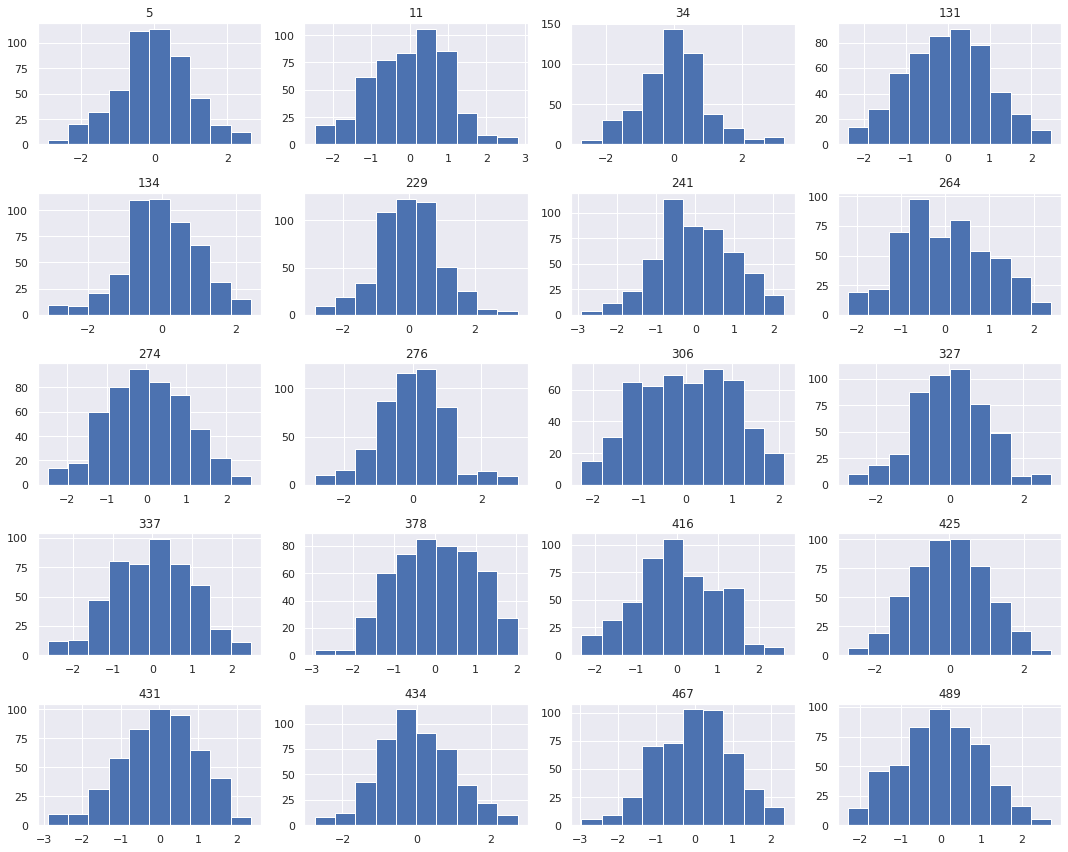

In [14]:
axs = data.drop('class', axis=1).T.loc[:, rand_samples].hist(figsize=(15, 12), layout=(5,4))
plt.tight_layout()
plt.show()

1. Descriptive statistics suggest has been previously standard scaled (mean=0 and standard deviaton = 1). This woudl explain why the data appears to range between -3 and 3.
2. Nonetheless, distribution of data for some observations is not normal.

# Split into training and testing

Before digging deeper, let's split data into training and testing to avoid leaking information in any way.

- `data` -> constains all sensor data
- `data_x` -> contains index of sensor data
- `data_y` -> contains class of data

In [15]:
data.head()

,class,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,...,1.120756,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,...,0.386403,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,...,0.394463,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,...,-0.952804,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,...,0.776188,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213


In [16]:
data_X = data.drop('class', axis=1).head(n=100)
data_y = data['class'].head(n=100)

In [17]:
train_X, test_X, train_y, test_y = (
    train_test_split(data_X, data_y, stratify=data_y,
                     shuffle=True, random_state=SEED)
)

# tsfresh

`tsfresh`, Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests, is a Python library useful for extracting and selecting features from timeseries data, essentially turning a timeseries with _t_ time points into _n_ features. It's built using Dask, a python library for parallel and distributed computing. This means you can distribute the tasks of extraction and selection across clusters for highly parallelized work, and that even in a single node, tasks can be sent to different cores for faster computations. This is particularly relevant because this library allows you to use its 72 feature calculations, according to their [lisf ot calculated features page](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) at the time of creation of this notebook. These functions, depending on the settings, may yield hundreds of features for a single timeseries. Read more in their [docs page](https://tsfresh.readthedocs.io/en/latest/index.html).

This is one of the approaches for solving the problem that will be displayed here: extracting relevant features from each time series as a whole.

**Note** This library also allows for sliding window creation and computation, but this approach won't be presented in the current notebook.

Necessary imports (made here instead of header for proximity with code and easier check)

In [18]:
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import impute
from sklearn.preprocessing import StandardScaler

tsfresh is able to handle a few [data formats](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html) as inputs. Leveraging the stacked one we already have, we just nees to expose an id column (currently in the index):

In [19]:
def melt(data):
    data_melt = (data
               .reset_index()
               .melt(id_vars='index', var_name='ts', value_name='value')
               .set_index(['index', 'ts']))
    data_stacked = data_melt.reset_index()
    return data_stacked

def dataframe_with_index(data):
    return pd.DataFrame(index=data.index)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate

In [ ]:
# TODO: automatize pca n_components
pipeline = Pipeline([
    ('augmenter', RelevantFeatureAugmenter(column_id='index', column_sort='ts', n_jobs=NJOBS)),
    ('scaler', MaxAbsScaler()),
    ('reduce_dim', PCA(n_components=5)),
    ('clf', RandomForestClassifier(n_jobs=NJOBS, verbose=2))
], verbose=True)

In [ ]:
# assert {j for j in train_y.index if j in data_X.index} == {j for j in train_y.index}

In [ ]:
pipeline.set_params(augmenter__timeseries_container=melt(train_X))
pipeline.fit(dataframe_with_index(train_y), train_y)

In [ ]:
pipeline.get_params()

In [ ]:
pipeline.set_params(augmenter__timeseries_container=melt(train_X))
predicted = pipeline.predict(dataframe_with_index(train_y))

**To actual modelling**

In [ ]:
classifier = RandomForestClassifier()

In [ ]:
# baseline results using cross validation
cv_results = cross_validate(classifier, tsfresh_train_X_decorrelated, tsfresh_train_y,
                            cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=NJOBS,
                            verbose=2)

In [ ]:
for metric in ['test_f1', 'test_precision', 'test_recall']:
    print(f'{metric}: {round(np.mean(cv_results[metric]), 4)}')

## Testing pipeline of tsfresh example

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

# Download dataset
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
download_robot_execution_failures()

pipeline = Pipeline([
                        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
                        ('classifier', RandomForestClassifier())
                    ])

In [32]:
df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(X, y)

Feature Extraction: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Pipeline(memory=None,
         steps=[('augmenter',
                 RelevantFeatureAugmenter(chunksize=None, column_id='id',
                                          column_kind=None, column_sort='time',
                                          column_value=None,
                                          default_fc_parameters=None,
                                          disable_progressbar=False,
                                          fdr_level=0.05,
                                          filter_only_tsfresh_features=True,
                                          hypotheses_independent=False,
                                          kind_to_fc_parameters=None,
                                          ml_task='auto', n_jobs=2,
                                          profile=False,
                                          prof...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='g

In [42]:
df_ts

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [23]:
type(df_ts)

pandas.core.frame.DataFrame

In [24]:
[type(s) for s in (y, df_ts , X) ]

[pandas.core.series.Series,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame]

In [35]:
train_X_, test_X_, train_y_, test_y_, train_df_ts, test_df_ts = (
    train_test_split(X, y, df_ts, stratify=y,
                     shuffle=True, random_state=SEED)
)

ValueError: Found input variables with inconsistent numbers of samples: [88, 88, 1320]

In [26]:
train_X_.head()

""
66
77
59
50
47


In [27]:
train_y

58    1.0
65    1.0
97   -1.0
43    1.0
0    -1.0
     ... 
42   -1.0
25   -1.0
69    1.0
70    1.0
40    1.0
Name: class, Length: 75, dtype: float64

In [28]:
df_ts.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


In [30]:
pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(train_X, train_y)

Feature Extraction: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


KeyError: "None of [Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',\n       ...\n       '490', '491', '492', '493', '494', '495', '496', '497', '498', '499'],\n      dtype='object', length=500)] are in the [columns]"

In [34]:
pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.score(test_X, test_y)

Feature Extraction: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').